<a href="https://colab.research.google.com/github/PranjalSahu/OAI_analysis_2/blob/pranjal/DaskComputationCoiled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install packages

# Remember to Restart runtime after installation


!pip install itk==5.3rc4
!pip install vtk
!pip install itkwidgets
!pip install icon-registration==0.3.4
#!pip install "dask[complete]"
#!pip install coiled dask distributed
!pip install tornado==6.1
!pip install coiled
!pip install torch
!pip install jupyter
!pip install girder_client
!pip install git+https://github.com/uncbiag/mermaid.git
!pip install git+https://github.com/uncbiag/easyreg.git
!pip install git+https://github.com/PranjalSahu/OAI_analysis_2.git#egg=oai_package

In [6]:
# All Imports

import numpy as np
import itk
import vtk
import itkwidgets
import icon_registration
import icon_registration.itk_wrapper as itk_wrapper
import icon_registration.pretrained_models as pretrained_models
from oai_analysis_2 import mesh_processing as mp

import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

import boto3
import coiled
import dask
from dask import delayed, compute, visualize
from dask.distributed import Client, progress, LocalCluster

In [ ]:
# Create the environment

if False:
  # coiled.create_software_environment(
  #   name="oai4",
  #   pip="coiled_requirements.txt",
  # )
  coiled.create_software_environment(
    name="oai4",
    container="pranjalsahu/pranjal-sahu-oai4:cf409eeb-435c-4976-afd4-6a5118d6b683",
  )

Creating new software environment
Creating container-only software environment
Successfully saved software environment build


In [14]:
# Create Dask Client. This will also spawn dask worker and scheduler

use_coiled = True

if use_coiled:
  name = None
  cluster = coiled.Cluster(n_workers=1,
                         worker_cpu=4,
                         worker_memory='12G',
                         name=name,
                         software='pranjal-sahu/oai4')
  client = dask.distributed.Client(cluster, 
                                   serializers=['pickle', 'dask'],
                                   deserializers=['pickle', 'dask'])
  client
else:
  cluster = LocalCluster(processes=False)
  client = Client(cluster)
  client

Output()

Found software environment build
Created fw rule: inbound [8786-8787] [0.0.0.0/0] []
Created FW rules: coiled-dask-pranjal09-151177-firewall
Created fw rule: cluster [0-65535] [None] [coiled-dask-pranjal09-151177-firewall -> coiled-dask-pranjal09-151177-firewall]
Created fw rule: cluster [0-65535] [None] [coiled-dask-pranjal09-151177-cluster-firewall -> coiled-dask-pranjal09-151177-cluster-firewall]
Created scheduler VM: coiled-dask-pranjal09-151177-scheduler (type: t3a.medium, ip: ['34.201.138.133'])


distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| blosc   | 1.10.6 | None      | None    |
+---------+--------+-----------+---------+


In [4]:
# For fetching files from S3

import boto3
s3 = boto3.resource("s3")

def show_contents_s3_bucket(bucket_name):
  import boto3

  s3     = boto3.resource("s3")
  bucket = s3.Bucket(bucket_name)

  all_objects = []
  for obj in bucket.objects.all():
    all_objects.append(str(obj.key))
  
  return ",".join(all_objects)

#print(f'filename : {obj.key} ')
#s3.Bucket(bucket_name).download_file(obj.key, './OAIData1/'+obj.key)
    
bucket_name = 'oaisample1'
show_contents_s3_bucket(bucket_name)

'FC_probmap.nii.gz,TC_probmap.nii.gz,atlas_fc.nii.gz,atlas_image.nii.gz,atlas_mask_step_10.nii.gz,atlas_tc.nii.gz,image_preprocessed.nii.gz'

In [20]:
# Read File from S3 from Dask workers inside the EC2 instances
# Now finish the pipeline

@delayed
def show_contents_s3_bucket_a(bucket_name, filename):
  import boto3
  import itk

  s3     = boto3.resource("s3")
  bucket = s3.Bucket(bucket_name)

  #all_objects = []
  #for obj in bucket.objects.all():
  #  all_objects.append(str(obj.key))
  #all_files = ",".join(all_objects)

  s3.Bucket(bucket_name).download_file(filename, filename)
  itk_image = itk.imread(filename)
  return itk_image.shape


filename   = 'atlas_image.nii.gz'
output_str = show_contents_s3_bucket_a(bucket_name, filename)

l = compute(output_str)
print(l)

((160, 384, 384),)


In [16]:
cluster

In [ ]:
#client.close()
#cluster.close()

Cluster deleted successfully.

In [ ]:
print(dask.__version__)
import distributed
print(distributed.__version__)
print(distributed.__path__)

2022.02.0
2022.02.0
['/usr/local/lib/python3.7/dist-packages/distributed']


In [ ]:
# Download the relevant files such as input image, atlas image, segmented TC and FC maps

!girder-client --api-url https://data.kitware.com/api/v1 localsync 621a5d784acac99f426c143b OAIData

Local metadata does not exists. Falling back to download.
[####################################]  74.74M/74.74M  100%  atlas_image.nii.gz          
[####################################]  76.70M/76.70M  100%  FC_probmap.nii.gz          
[####################################]  27.96M/27.96M  100%  image_preprocessed.nii.gz          
[####################################]  76.66M/76.66M  100%  TC_probmap.nii.gz          


In [ ]:
# All Function Definitions with Dask Delayed Decorator to perform parallel Computing

#@delayed(nout=2)
def read_images(image_preprocessed, atlas_image):
    image_A = itk.imread(image_preprocessed, itk.D)
    image_B = itk.imread(atlas_image, itk.D)

    fc_prob_file = './OAIData/FC_probmap.nii.gz'
    FC_prob = itk.imread(fc_prob_file)

    tc_prob_file = './OAIData/TC_probmap.nii.gz'
    TC_prob = itk.imread(tc_prob_file)

    return image_A, image_B, FC_prob, TC_prob

def register_images(image_A, image_B):
    model = pretrained_models.OAI_knees_gradICON_model()
    model.to('cpu')

    # Register the images
    phi_AB, phi_BA = itk_wrapper.register_pair(model, image_A, image_B)
    return phi_AB

@delayed
def deform_probmap_FC(phi_AB, image_A, image_B, FC_prob):
    #import itkConfig
    #itkConfig.LazyLoading = False
    import itk
    #fc_prob_file = './OAIData/FC_probmap.nii.gz'
    #FC_prob = itk.imread(fc_prob_file)

    # interpolator = itk.LinearInterpolateImageFunction.New(image_A)
    # warped_image_FC = itk.resample_image_filter(FC_prob, 
    #     transform=phi_AB, 
    #     interpolator=interpolator,
    #     size=itk.size(image_B),
    #     output_spacing=itk.spacing(image_B),
    #     output_direction=image_B.GetDirection(),
    #     output_origin=image_B.GetOrigin()
    # )

    return image_A.shape
    #return warped_image_FC

@delayed
def deform_probmap_FC_paramA(phi_AB):
    #import itkConfig
    #itkConfig.LazyLoading = False
    #import itk
    #return itk.dict_from_transform(phi_AB)["transformName"]#.GetNumberOfParameters()
    #return warped_image_FC
    return phi_AB["transformName"]

@delayed
def deform_probmap_TC(phi_AB, image_A, image_B, TC_prob):
    #import itkConfig
    #itkConfig.LazyLoading = False
    #import itk
    #tc_prob_file = './OAIData/TC_probmap.nii.gz'
    #TC_prob = itk.imread(tc_prob_file)

    interpolator = itk.LinearInterpolateImageFunction.New(image_A)
    warped_image_TC = itk.resample_image_filter(TC_prob, 
        transform=phi_AB, 
        interpolator=interpolator,
        size=itk.size(image_B),
        output_spacing=itk.spacing(image_B),
        output_direction=image_B.GetDirection(),
        output_origin=image_B.GetOrigin()
    )

    return warped_image_TC

# Convert from VTK Mesh to ITK Mesh to make it serializable
def get_itk_mesh(vtk_mesh):
    #import itkConfig
    #itkConfig.LazyLoading = False
    #import itk

    Dimension = 3
    PixelType = itk.D
    
    MeshType = itk.Mesh[PixelType, Dimension]
    itk_mesh = MeshType.New()
    
    # Get points array from VTK mesh
    points = vtk_mesh.GetPoints().GetData()
    points_numpy = np.array(points).flatten().astype('float32')
        
    polys = vtk_mesh.GetPolys().GetData()
    polys_numpy = np.array(polys).flatten()

    # Triangle Mesh
    vtk_cells_count = vtk_mesh.GetNumberOfPolys()
    polys_numpy = np.reshape(polys_numpy, [vtk_cells_count, Dimension+1])

    # Extracting only the points by removing first column that denotes the VTK cell type
    polys_numpy = polys_numpy[:, 1:]
    polys_numpy = polys_numpy.flatten().astype(np.uint64)

    # Get point data from VTK mesh to insert in ITK Mesh
    point_data_numpy = np.array(vtk_mesh.GetPointData().GetScalars())#.astype('float64')
    
    # Get cell data from VTK mesh to insert in ITK Mesh
    cell_data_numpy = np.array(vtk_mesh.GetCellData().GetScalars())#.astype('float64')
    
    itk_mesh.SetPoints(itk.vector_container_from_array(points_numpy))
    itk_mesh.SetCellsArray(itk.vector_container_from_array(polys_numpy), itk.CommonEnums.CellGeometry_TRIANGLE_CELL)
    itk_mesh.SetPointData(itk.vector_container_from_array(point_data_numpy))
    itk_mesh.SetCellData(itk.vector_container_from_array(cell_data_numpy))    
    return itk_mesh
    
@delayed
def get_thickness_FC(warped_image_FC):
    #import itkConfig
    #itkConfig.LazyLoading = False
    #import itk

    distance_inner_FC, distance_outer_FC = mp.get_thickness_mesh(warped_image_FC, mesh_type='FC')
    distance_inner_FC = get_itk_mesh(distance_inner_FC)
    return distance_inner_FC

@delayed
def get_thickness_TC(warped_image_TC):
    #import itkConfig
    #itkConfig.LazyLoading = False
    #import itk

    distance_inner_TC, distance_outer_TC = mp.get_thickness_mesh(warped_image_TC, mesh_type='TC')
    distance_inner_TC = get_itk_mesh(distance_inner_TC)
    return distance_inner_TC

#@delayed(nout=2)
def get_paths():
    import numpy as np
    import itk
    import vtk
    import itkwidgets
    import icon_registration
    import icon_registration.itk_wrapper as itk_wrapper
    import icon_registration.pretrained_models as pretrained_models
    from oai_analysis_2 import mesh_processing as mp

    image_preprocessed = "./OAIData/image_preprocessed.nii.gz"
    atlas_image = "./OAIData/atlas_image.nii.gz"

    return image_preprocessed, atlas_image

#@delayed
def only_register_images(image_A, image_B):
  #import itkConfig
  #itkConfig.LazyLoading = False
  #import itk
  import numpy as np
  import itk
  import vtk
  import itkwidgets
  import icon_registration
  import icon_registration.itk_wrapper as itk_wrapper
  import icon_registration.pretrained_models as pretrained_models
  from oai_analysis_2 import mesh_processing as mp

  phi_AB  = register_images(image_A=image_A, image_B=image_B)
  return phi_AB

@delayed
def import_all():
  import numpy as np
  #import itkConfig
  #itkConfig.LazyLoading = False
  import itk
  import vtk
  import itkwidgets
  import icon_registration
  import icon_registration.itk_wrapper as itk_wrapper
  import icon_registration.pretrained_models as pretrained_models
  from oai_analysis_2 import mesh_processing as mp

  return True

In [ ]:
img_np = np.random.rand(5, 5)
print(img_np.shape)

img = itk.image_from_array(img_np)
print(img.shape)

(5, 5)
(5, 5)


In [ ]:
# Create a test mesh

m = itk.Mesh.F3.New()
p = np.random.rand(5, 3).astype('float32')
print(p.shape, p.dtype)
m.SetPoints(itk.vector_container_from_array(p.flatten()))

#md = itk.dict_from_mesh(m)
#print(md)

(5, 3) float32


In [ ]:
@delayed
def perform_sum1(img_temp):
  import itk
  mesh = itk.mesh_from_dict(img_temp)
  return img_temp['dimension']

  #return np.sum(img_temp['points'])
  #return itk.di
  #import itkConfig
  #itkConfig.LazyLoading = False
  #import itk
  #return itk.image_from_array(img_temp)
  #a = np.array(img_temp)
  #return a#np.sum(img_temp)

In [ ]:
# Create Dask Computation Graph

result = []

#import_done = import_all()
image_preprocessed, atlas_image   = get_paths()

image_A, image_B, FC_prob, TC_prob  = read_images(image_preprocessed, atlas_image)
phi_AB            = only_register_images(image_A, image_B)

warped_image_FC = deform_probmap_FC(phi_AB, image_A, image_B, FC_prob)
warped_image_TC = deform_probmap_TC(phi_AB, image_A, image_B, TC_prob)

thickness_FC = get_thickness_FC(warped_image_FC)
thickness_TC = get_thickness_TC(warped_image_TC)

result.append(thickness_FC)
result.append(thickness_TC)

In [ ]:
numParam = deform_probmap_FC_paramA(phi_AB)


In [ ]:
m1 = itk.dict_from_mesh(m)
sumImg = perform_sum1(m1)

In [ ]:
#cluster.close()

Cluster deleted successfully.

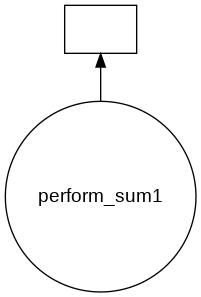

In [ ]:
# Visualize Dask Computation Graph

visualize(sumImg)

In [ ]:
# Perform computation
#%%time
l = compute(sumImg)

In [ ]:
print(l)

(3,)


In [ ]:
import pickle
import cloudpickle
a = itk.image_from_array(img_np)
b = cloudpickle.loads(pickle.dumps(a))
print(b)

In [ ]:
!pip install cloudpickle

![DaskProgress](https://user-images.githubusercontent.com/1044135/163692457-40a41395-3d83-4928-9445-528cd025a7b9.png)


In [ ]:
# Write the result meshes

distance_inner_FC = l[0]
distance_inner_TC = l[1]

itk.meshwrite(distance_inner_FC, 'itk_distance_inner_FC.vtk')
itk.meshwrite(distance_inner_TC, 'itk_distance_inner_TC.vtk')

In [ ]:
# Visualize the meshes with thickness as cell data

# To enable running the itkwidgets window on colab
from google.colab import output
output.enable_custom_widget_manager()

a1 = vtk.vtkPolyDataReader()
a1.SetFileName('itk_distance_inner_FC.vtk')
a1.Update()
distance_inner_FC = a1.GetOutput()

itkwidgets.view(geometries=[distance_inner_FC])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…